In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# -------------------------- 1. 配置实验参数 --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 优先用GPU
batch_size = 64
learning_rate = 0.001
epochs = 10  # 训练轮次（CIFAR10简单，10轮足够看到效果）

In [3]:
# -------------------------- 2. 定义AlexNet模型（适配CIFAR10） --------------------------
# 原始AlexNet针对224×224图像，CIFAR10是32×32，需调整卷积核和池化层参数
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):  # CIFAR10有10个类别
        super(AlexNet, self).__init__()
        # 特征提取层：5个卷积层 + 3个最大池化层
        self.features = nn.Sequential(
            # 卷积层1：3→64，核11→3（适配小图像），步长4→1，填充2
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            # LRN层1：论文配置n=5，k=2, alpha=1e-4, beta=0.75
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出：64×16×16
            
            # 卷积层2：64 -> 192，核5 -> 3，填充2
            nn.Conv2d(64, 192, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            # LRN层2
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出：192×8×8
            
            # 卷积层3：192→384，核3，填充1
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # 卷积层4：384→256，核3，填充1
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # 卷积层5：256→256，核3，填充1
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出：256×4×4
        )
        
        # 分类层：3个全连接层
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # 防止过拟合
            nn.Linear(256 * 4 * 4, 4096),  # 输入：256×4×4=4096
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes)  # 输出10个类别概率
        )

    def forward(self, x):
        x = self.features(x)  # 特征提取
        x = x.view(x.size(0), -1)  # 展平（batch_size, 256×4×4）
        x = self.classifier(x)  # 分类
        return x


In [5]:
# -------------------------- 3. 数据准备（CIFAR10数据集） --------------------------
# 数据预处理：归一化、随机增强（训练集）
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR10均值方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(
    root='./datasets', train=True, download=True, transform=transform_train
)
test_dataset = datasets.CIFAR10(
    root='./datasets', train=False, download=True, transform=transform_test
)

# 数据加载器（批量读取数据）
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR10类别名称（用于后续可视化）
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

100.0%


In [6]:
# -------------------------- 4. 初始化模型、损失函数、优化器 --------------------------
model = AlexNet(num_classes=10).to(device)  # 模型移到GPU/CPU
criterion = nn.CrossEntropyLoss()  # 交叉熵损失（分类任务常用）
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam优化器

# -------------------------- 5. 训练函数 --------------------------
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()  # 训练模式（启用Dropout）
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播+参数更新
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新参数
        
        running_loss += loss.item()
        
        # 打印训练进度
        if batch_idx % 100 == 99:  # 每100个batch打印一次
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0


In [7]:
# -------------------------- 6. 测试函数 --------------------------
def test(model, test_loader, criterion):
    model.eval()  # 测试模式（禁用Dropout）
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 禁用梯度计算（节省内存）
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)  # 取概率最大的类别
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()  # 统计正确个数
    
    # 计算测试集损失和准确率
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    print(f'\nTest Set: Average Loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')
    return accuracy

# -------------------------- 7. 启动训练和测试 --------------------------
print(f"Training on {device}...")
best_accuracy = 0.0
# for epoch in range(epochs):
#     train(model, train_loader, criterion, optimizer, epoch)
#     current_accuracy = test(model, test_loader, criterion)
    
#     # 保存最优模型
#     if current_accuracy > best_accuracy:
#         best_accuracy = current_accuracy
#         torch.save(model.state_dict(), 'results/alexnet_cifar10_best.pth')
#         print(f"Saved best model with accuracy: {best_accuracy:.2f}%\n")

# print(f"Training Finished! Best Accuracy: {best_accuracy:.2f}%")


Training on cpu...
Epoch [1/10], Batch [100/782], Loss: 2.1783
Epoch [1/10], Batch [200/782], Loss: 1.9728
Epoch [1/10], Batch [300/782], Loss: 1.8626
Epoch [1/10], Batch [400/782], Loss: 1.7660
Epoch [1/10], Batch [500/782], Loss: 1.6747
Epoch [1/10], Batch [600/782], Loss: 1.6193
Epoch [1/10], Batch [700/782], Loss: 1.5739

Test Set: Average Loss: 1.5522, Accuracy: 4296/10000 (42.96%)

Saved best model with accuracy: 42.96%

Epoch [2/10], Batch [100/782], Loss: 1.5317
Epoch [2/10], Batch [200/782], Loss: 1.4714
Epoch [2/10], Batch [300/782], Loss: 1.4165
Epoch [2/10], Batch [400/782], Loss: 1.4126
Epoch [2/10], Batch [500/782], Loss: 1.3548
Epoch [2/10], Batch [600/782], Loss: 1.3543
Epoch [2/10], Batch [700/782], Loss: 1.3433

Test Set: Average Loss: 1.1950, Accuracy: 5690/10000 (56.90%)

Saved best model with accuracy: 56.90%

Epoch [3/10], Batch [100/782], Loss: 1.2687
Epoch [3/10], Batch [200/782], Loss: 1.2437
Epoch [3/10], Batch [300/782], Loss: 1.2085
Epoch [3/10], Batch [400/

In [ ]:
# -------------------------- 8. 单图推理演示（加载最优模型） --------------------------
def infer_single_image(model_path, image_path, transform):
    # 加载模型
    model = AlexNet(num_classes=10).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 预处理图像
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # 增加batch维度
    
    # 推理
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = output.max(1)
        predicted_class = classes[predicted.item()]
    
    # 显示图像和结果
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

In [10]:
# 从test_batch中加载图片
import pickle
def load_cifar10_batch(batch_path):
    with open(batch_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    images = batch[b'data']
    labels = batch[b'labels']
    images = images.reshape(-1, 3, 32, 32).astype(np.uint8)
    return images, labels

In [20]:
images, labels = load_cifar10_batch('./datasets/cifar-10-batches-py/test_batch')
img, label = images[0], labels[0]
# save the image
from PIL import Image
img1_pil = Image.fromarray(np.transpose(img, (1, 2, 0)))
img1_pil.save('test_image.jpg')
print(label)

3


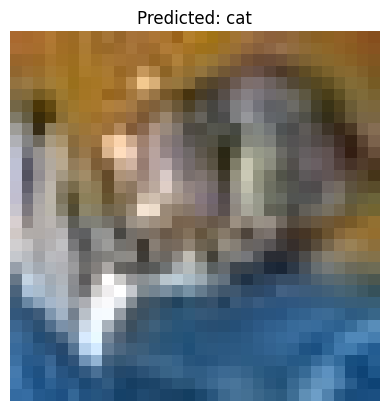

In [15]:
# 示例：用一张自己的图片测试（替换为你的图片路径）
# 注意：图片尺寸建议32×32（或自动缩放），类别需在CIFAR10中
infer_single_image('./results/alexnet_cifar10_best.pth', 'test_image.jpg', transform_test)

## 统计参数

In [50]:
# -------------------------- 修复后的参数统计函数 --------------------------
def count_model_params(model, verbose=True):
    """
    统计模型参数数量（修复列表格式化报错）
    :param model: 输入的模型
    :param verbose: 是否打印每层参数分布（True=打印，False=仅返回总数）
    :return: 总参数量、可训练参数量
    """
    total_params = 0  # 总参数（包括不可训练的）
    trainable_params = 0  # 可训练参数
    
    if verbose:
        print("="*90)
        print("Layer Name           | Param Shape        | Param Num (M)  | Trainable")
        print("="*90)
    
    for name, param in model.named_parameters():
        # 统计单个参数的数量
        param_num = param.numel()
        total_params += param_num
        if param.requires_grad:
            trainable_params += param_num
        
        # 修复：将列表转为字符串后再格式化（核心修改）
        if verbose:
            param_shape_str = str(list(param.shape))  # 列表转字符串
            param_num_m = param_num
            trainable_flag = "√" if param.requires_grad else "×"
            # 调整格式化方式：对字符串做对齐，而非列表
            print(f"{name:<20} | {param_shape_str:<18} | {param_num_m:<14} | {trainable_flag}")
    
    # 总参数格式化
    total_params_m = total_params / 1e6
    trainable_params_m = trainable_params / 1e6
    
    if verbose:
        print("="*90)
        print(f"Total Params:     {total_params_m:.4f} M (={total_params,})")
        print(f"Trainable Params: {trainable_params_m:.4f} M (={trainable_params,})")
        print(f"Non-trainable:    {(total_params - trainable_params)}")
        print("="*90)
    
    return total_params, trainable_params

In [51]:
total_params, trainable_params = count_model_params(model)
    
# 验证输入输出
dummy_input = torch.randn(1, 3, 32, 32)
output = model(dummy_input)
print(f"\nModel Input Shape: {dummy_input.shape}")
print(f"Model Output Shape: {output.shape} (对应10个类别)")

Layer Name           | Param Shape        | Param Num (M)  | Trainable
features.0.weight    | [64, 3, 3, 3]      | 1728           | √
features.0.bias      | [64]               | 64             | √
features.4.weight    | [192, 64, 3, 3]    | 110592         | √
features.4.bias      | [192]              | 192            | √
features.8.weight    | [384, 192, 3, 3]   | 663552         | √
features.8.bias      | [384]              | 384            | √
features.10.weight   | [256, 384, 3, 3]   | 884736         | √
features.10.bias     | [256]              | 256            | √
features.12.weight   | [256, 256, 3, 3]   | 589824         | √
features.12.bias     | [256]              | 256            | √
classifier.1.weight  | [4096, 4096]       | 16777216       | √
classifier.1.bias    | [4096]             | 4096           | √
classifier.4.weight  | [4096, 4096]       | 16777216       | √
classifier.4.bias    | [4096]             | 4096           | √
classifier.6.weight  | [10, 4096]         | 409